<a href="https://colab.research.google.com/github/jdcneto/Modulation-Classification/blob/main/Modulation_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Modulation Recognition: RML2016.10a Dataset 


# Import Packages

In [5]:
# Import packages
%matplotlib inline
import _pickle as cPickle
import numpy as np
import os, random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
from sklearn.metrics import confusion_matrix, classification_report
import datetime
import matplotlib.pyplot as plt
import seaborn as sns


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [43]:
print(torch.cuda.get_device_name(torch.cuda.current_device()))

Tesla T4


In [7]:
# setting seed for reproducibility
seed = 10
np.random.seed(seed)
torch.manual_seed(seed);

# Dataset setup

In [8]:
# Load the dataset ...
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
filename = "/content/drive/MyDrive/RML2016.10a_dict.dat"
open_file = open(filename,'rb')
Xd = cPickle.load(open_file, encoding='latin1')

In [10]:
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)
print(X.shape)

(220000, 2, 128)


In [11]:
# Partition the data into train/test, 80% to train. while keeping SNR and Mod labels handy for each
n_examples = X.shape[0]
n_train = int(n_examples*.8)
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]

In [12]:
print(X_train.shape, X_test.shape)

(176000, 2, 128) (44000, 2, 128)


In [13]:
print('modulation labels: {}'.format(mods))

modulation labels: ['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']


In [14]:
# separating labels
train_labels = np.array(list(map(lambda x: mods.index(lbl[x][0]), train_idx)), dtype=int)
test_labels  = np.array(list(map(lambda x: mods.index(lbl[x][0]), test_idx)), dtype=int)

In [15]:
print(train_labels.shape, test_labels.shape)

(176000,) (44000,)


In [16]:
# reshaping data - add one dimension
x_train = np.expand_dims(X_train, axis=1)
x_test  = np.expand_dims(X_test, axis=1)
print(x_train.shape, x_test.shape )

(176000, 1, 2, 128) (44000, 1, 2, 128)


In [17]:
# data loader to feed cnn model
x_train, x_test = torch.Tensor(x_train), torch.Tensor(x_test)
y_train, y_test = torch.Tensor(train_labels), torch.Tensor(test_labels)
 
train_dataset = TensorDataset(x_train, y_train.type(torch.LongTensor))
test_dataset  = TensorDataset(x_test, y_test.type(torch.LongTensor))

In [18]:
batch_size = 512
TrainLoader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
TestLoader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Building the CNN Model

In [19]:
# Dropout rate
dr = 0.6

In [20]:
# Build CNN model using Torch
class CovNet(nn.Module):
    def __init__(self):
        super(CovNet, self).__init__()
        self.conv1    = nn.Conv2d(1, 256, (1,7), padding=(0,3))
        self.b1  = nn.BatchNorm2d(256)
        nn.init.xavier_uniform_(self.conv1.weight,gain=nn.init.calculate_gain('relu'))
        self.dropout1 = nn.Dropout(dr)
        self.zeropad2 = nn.ZeroPad2d((0,2))
        self.conv2    = nn.Conv2d(256, 128, (1,7), padding=(0,3))
        nn.init.xavier_uniform_(self.conv2.weight,gain=nn.init.calculate_gain('relu'))
        self.b2  = nn.BatchNorm2d(128)
        self.dropout2 = nn.Dropout(dr)
        self.conv3    = nn.Conv2d(128, 80, (2,7), padding=(0,3))
        nn.init.xavier_uniform_(self.conv3.weight,gain=nn.init.calculate_gain('relu'))
        self.b3  = nn.BatchNorm2d(80)
        self.dropout3 = nn.Dropout(dr)
        self.fc1      = nn.Linear(80*128, 256)
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
        self.fc2      = nn.Linear(256, 128)
        nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='relu')
        self.dropout4 = nn.Dropout(dr)
        self.fc3      = nn.Linear(128, 64)
        nn.init.kaiming_normal_(self.fc3.weight, nonlinearity='relu')
        self.fc4      = nn.Linear(64, len(mods))
        nn.init.kaiming_normal_(self.fc4.weight, nonlinearity='sigmoid')
        
    def forward(self, x):
          x = F.relu(self.conv1(x))
          x= self.b1(x)
          x = self.dropout1(x)
          x = F.relu(self.conv2(x))
          x = self.dropout2(x)
          x= self.b2(x)
          x = F.relu(self.conv3(x))
          x = self.dropout3(x)
          x= self.b3(x)
          x = x.view(-1, 80*128)
          x = F.relu(self.fc1(x))
          x = F.relu(self.fc2(x))
          x = self.dropout4(x)
          x = F.relu(self.fc3(x))
          out = self.fc4(x)
          # x = self.fc2(x)
          # out = F.log_softmax(self.fc2(x), dim=1)
          return out
          
cnn = CovNet().to(device=device)

In [21]:
summary(cnn, (1,2,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 256, 2, 128]           2,048
       BatchNorm2d-2          [-1, 256, 2, 128]             512
           Dropout-3          [-1, 256, 2, 128]               0
            Conv2d-4          [-1, 128, 2, 128]         229,504
           Dropout-5          [-1, 128, 2, 128]               0
       BatchNorm2d-6          [-1, 128, 2, 128]             256
            Conv2d-7           [-1, 80, 1, 128]         143,440
           Dropout-8           [-1, 80, 1, 128]               0
       BatchNorm2d-9           [-1, 80, 1, 128]             160
           Linear-10                  [-1, 256]       2,621,696
           Linear-11                  [-1, 128]          32,896
          Dropout-12                  [-1, 128]               0
           Linear-13                   [-1, 64]           8,256
           Linear-14                   

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)

In [23]:
# creating dictionary for statistics
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [24]:
def cnn_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

# Traininig the Model

In [25]:
num_epochs = 50
min_val_loss = np.inf
for epoch in range(1, num_epochs+1):  # loop over the dataset multiple times
    cnn.train()   
    train_epoch_loss = 0.0
    train_epoch_acc  = 0.0

    for batch_idx, (data, target) in enumerate(TrainLoader):
        
        data, target = data.to(device=device), target.to(device=device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = cnn(data)
        loss = criterion(outputs, target)
        acc = cnn_acc(outputs, target)
        loss.backward()
        optimizer.step()

        train_epoch_loss += loss.item()
        train_epoch_acc += acc.item()

        # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0.0
        val_epoch_acc = 0.0
        
        cnn.eval()
        for X_val_batch, y_val_batch in TestLoader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = cnn(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = cnn_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()

    loss_stats['train'].append(train_epoch_loss/len(TrainLoader))
    loss_stats['val'].append(val_epoch_loss/len(TestLoader))
    accuracy_stats['train'].append(train_epoch_acc/len(TrainLoader))
    accuracy_stats['val'].append(val_epoch_acc/len(TestLoader))
                              
    print(f'Epoch {epoch}:  | Train Loss: {train_epoch_loss/len(TrainLoader):.5f} | Val Loss: {val_epoch_loss/len(TestLoader):.5f} | Train Acc: {train_epoch_acc/len(TrainLoader):.3f} | Val Acc: {val_epoch_acc/len(TestLoader):.3f}')
    
    if min_val_loss > val_epoch_loss:
        min_val_loss = val_epoch_loss
          
        # Saving State Dict
        torch.save(cnn.state_dict(), 'saved_model.pth')

print('Finished Training')

Epoch 1:  | Train Loss: 1.90330 | Val Loss: 1.57230 | Train Acc: 28.997 | Val Acc: 40.465
Epoch 2:  | Train Loss: 1.50727 | Val Loss: 1.38244 | Train Acc: 42.506 | Val Acc: 48.372
Epoch 3:  | Train Loss: 1.38167 | Val Loss: 1.34752 | Train Acc: 47.355 | Val Acc: 49.442
Epoch 4:  | Train Loss: 1.33443 | Val Loss: 1.33845 | Train Acc: 48.657 | Val Acc: 49.151
Epoch 5:  | Train Loss: 1.30879 | Val Loss: 1.26590 | Train Acc: 49.529 | Val Acc: 51.395
Epoch 6:  | Train Loss: 1.29054 | Val Loss: 1.33186 | Train Acc: 50.474 | Val Acc: 50.512
Epoch 7:  | Train Loss: 1.27563 | Val Loss: 1.24164 | Train Acc: 51.474 | Val Acc: 52.965
Epoch 8:  | Train Loss: 1.26310 | Val Loss: 1.25996 | Train Acc: 52.015 | Val Acc: 52.233
Epoch 9:  | Train Loss: 1.25259 | Val Loss: 1.24796 | Train Acc: 52.448 | Val Acc: 53.058
Epoch 10:  | Train Loss: 1.24285 | Val Loss: 1.24692 | Train Acc: 52.916 | Val Acc: 53.744
Epoch 11:  | Train Loss: 1.23379 | Val Loss: 1.24066 | Train Acc: 53.401 | Val Acc: 53.756
Epoch 12

# Evaluate and Plot Model Performance

In [36]:
#loading 
model = CovNet().to(device=device)
model.load_state_dict(torch.load('saved_model.pth',map_location=device))
model.eval()

CovNet(
  (conv1): Conv2d(1, 256, kernel_size=(1, 7), stride=(1, 1), padding=(0, 3))
  (b1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.6, inplace=False)
  (zeropad2): ZeroPad2d(padding=(0, 2), value=0.0)
  (conv2): Conv2d(256, 128, kernel_size=(1, 7), stride=(1, 1), padding=(0, 3))
  (b2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.6, inplace=False)
  (conv3): Conv2d(128, 80, kernel_size=(2, 7), stride=(1, 1), padding=(0, 3))
  (b3): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.6, inplace=False)
  (fc1): Linear(in_features=10240, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (dropout4): Dropout(p=0.6, inplace=False)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=11, bias=True)
)

In [111]:
for name, loader in [("train", TrainLoader), ("test", TestLoader)]:
  y_pred_list = []
  correct = 0
  total = 0
  with torch.no_grad():
      for inputs, labels in loader:
        inputs = inputs.to(device=device)
        labels = labels.to(device=device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, dim=1)
        y_pred_list.append(predicted.cpu().numpy())
        total += labels.shape[0]
        correct += int((predicted == labels).sum())

  print("Accuracy {}: {:.2%}".format(name , correct / total))
y_pred = [y for x in y_pred_list for y in x]

Accuracy train: 61.41%
Accuracy test: 56.75%


## Plot Model Statistics 

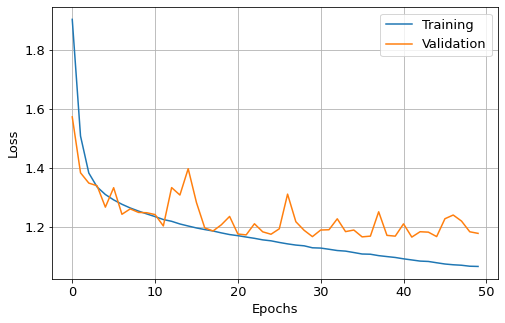

In [74]:
# Loss Figure plotting and saving figure
plt.figure(figsize=(8,5)) 
plt.grid() 
plt.plot(loss_stats['train'])
plt.plot(loss_stats['val'])
plt.legend(['Training','Validation'])
plt.ylabel('Loss'), plt.xlabel('Epochs')
plt.savefig('loss_curve.pdf'), plt.show();

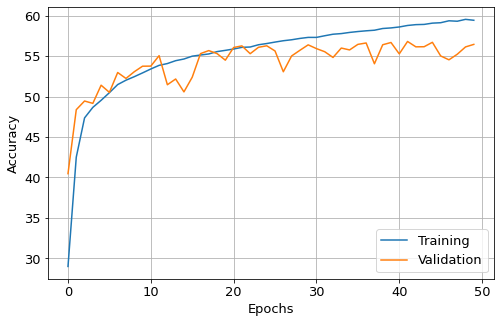

In [73]:
# Accuracy plotting and saving figure
plt.figure(figsize=(8,5)) 
plt.grid() 
plt.plot(accuracy_stats['train'])
plt.plot(accuracy_stats['val'])
plt.legend(['Training','Validation'])
plt.ylabel('Accuracy'), plt.xlabel('Epochs')
plt.savefig('acc_curve.pdf'), plt.show();

## Confusion Matrix and Classification Report

In [119]:
def plot_confusion_matrix(cm, title='Confusion Matrix', cmap=plt.cm.Blues, labels=[]):
    plt.figure(figsize=(8,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap);
    plt.title(title)
    plt.colorbar(ticks = np.arange(0.0,1.,.2))
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show();

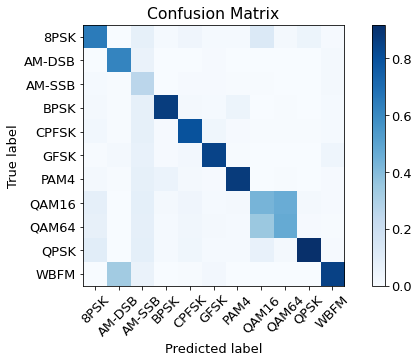

In [120]:
# Plot confusion matrix
cm = confusion_matrix(test_labels, y_pred, normalize='pred')
plot_confusion_matrix(cm, labels=mods)

In [32]:
# Classification Report
report = classification_report(test_labels, y_pred, target_names=mods)
print(report)

              precision    recall  f1-score   support

        8PSK       0.65      0.58      0.61      3920
      AM-DSB       0.62      0.76      0.68      3943
      AM-SSB       0.26      0.96      0.41      4127
        BPSK       0.87      0.60      0.71      3926
       CPFSK       0.80      0.63      0.70      4028
        GFSK       0.85      0.67      0.75      3978
        PAM4       0.88      0.62      0.73      4048
       QAM16       0.43      0.05      0.08      4080
       QAM64       0.48      0.53      0.50      3969
        QPSK       0.92      0.52      0.66      4074
        WBFM       0.85      0.33      0.47      3907

    accuracy                           0.57     44000
   macro avg       0.69      0.57      0.57     44000
weighted avg       0.69      0.57      0.57     44000



## Signal to Noise Ratio

In [33]:
# Defining function for new predictions
def make_prediction(y):
  with torch.no_grad():
    
    # Retrieve item
    y = y.to(device=device)
    # Generate prediction
    prediction = model(y)
    
    # Predicted class value using argmax
    _, predicted_class = torch.max(prediction, dim=1)
  
  return predicted_class.cpu().numpy()

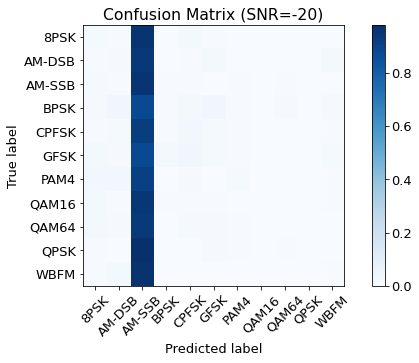

Overall Accuracy:  0.09893172317696237


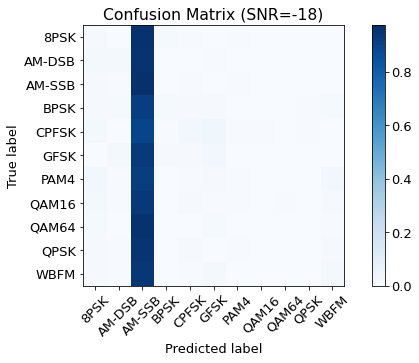

Overall Accuracy:  0.10124252185918085


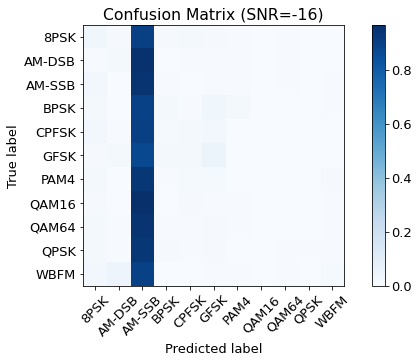

Overall Accuracy:  0.10170250896057348


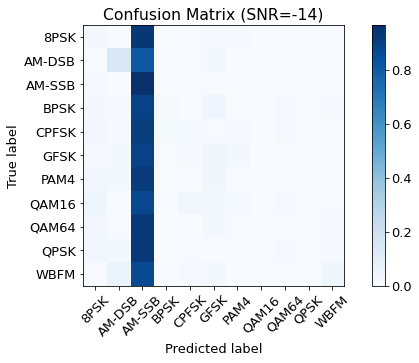

Overall Accuracy:  0.1135110294117647


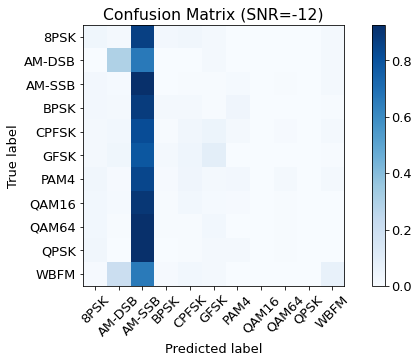

Overall Accuracy:  0.12827586206896552


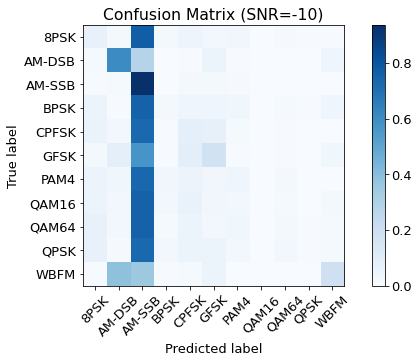

Overall Accuracy:  0.20320855614973263


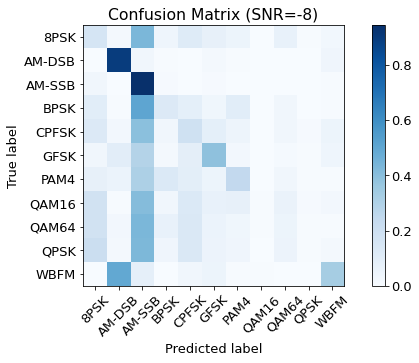

Overall Accuracy:  0.2968892955169259


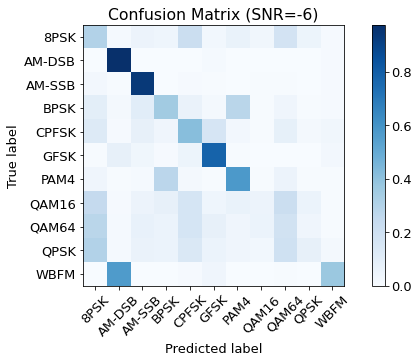

Overall Accuracy:  0.4528301886792453


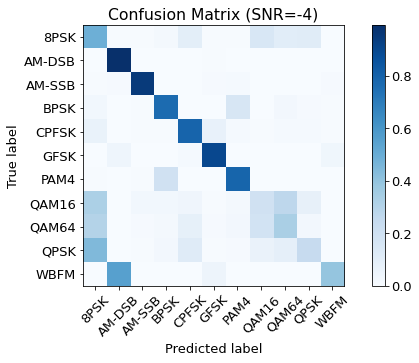

Overall Accuracy:  0.622439893143366


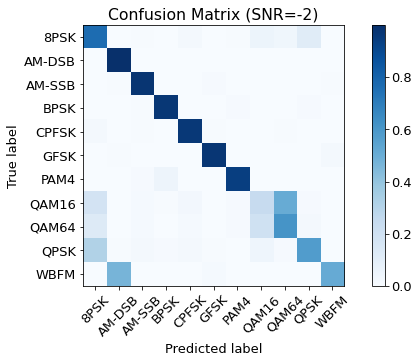

Overall Accuracy:  0.7737765466297323


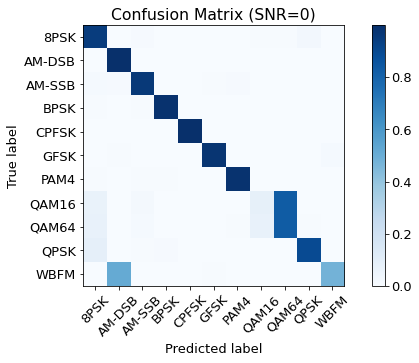

Overall Accuracy:  0.8379735280693748


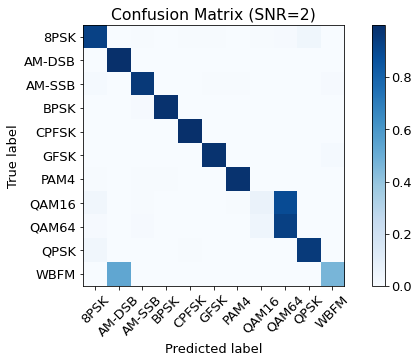

Overall Accuracy:  0.8421768707482993


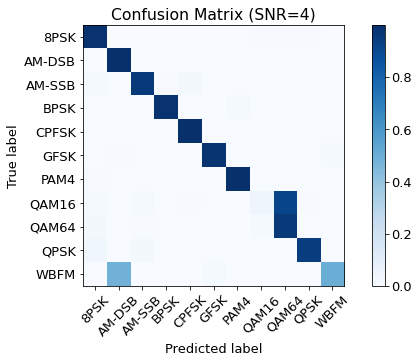

Overall Accuracy:  0.8425231583590649


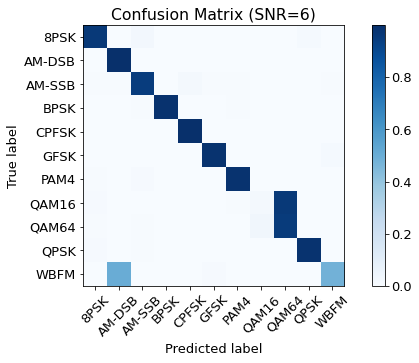

Overall Accuracy:  0.8565536205316223


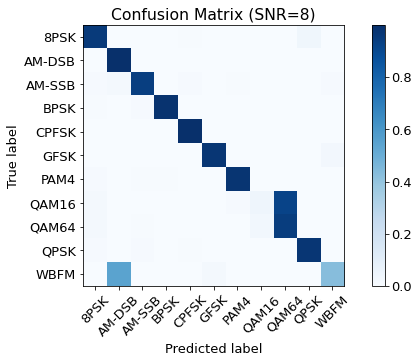

Overall Accuracy:  0.846777827850383


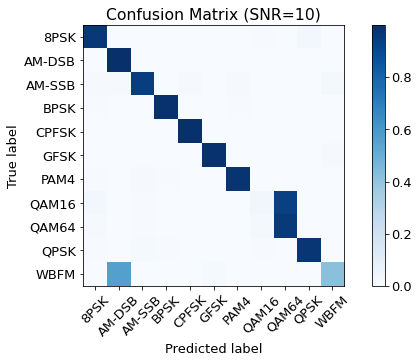

Overall Accuracy:  0.8442844284428442


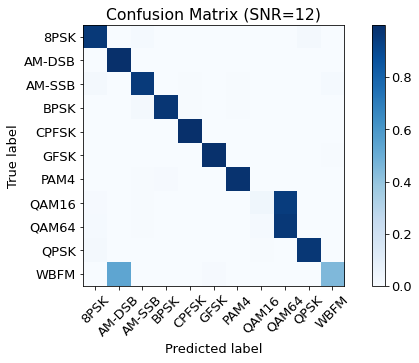

Overall Accuracy:  0.8471017800091283


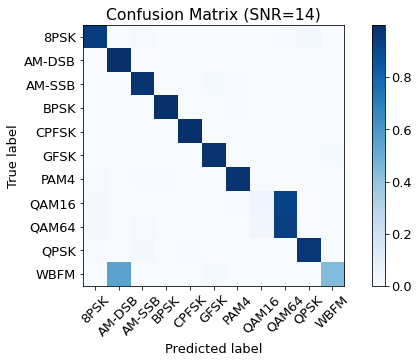

Overall Accuracy:  0.8498151571164511


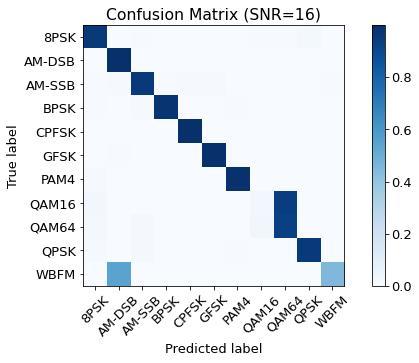

Overall Accuracy:  0.8364226135310473


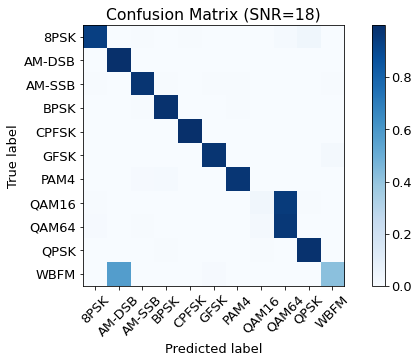

Overall Accuracy:  0.8502994011976048


In [121]:
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
    test_X_i = x_test[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = test_labels[np.where(np.array(test_SNRs)==snr)]   

    # estimate classes
    test_Y_i_hat = make_prediction(test_X_i)
    
    cm = confusion_matrix(test_Y_i, test_Y_i_hat)
    confnorm = np.zeros([len(mods),len(mods)])
    for i in range(0,len(mods)):
        confnorm[i,:] = cm[i,:] / np.sum(cm[i,:])

    plot_confusion_matrix(confnorm, labels=mods, title="Confusion Matrix (SNR=%d)"%(snr));
    
    cor = np.sum(np.diag(cm))
    ncor = np.sum(cm) - cor
    print("Overall Accuracy: ", cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)

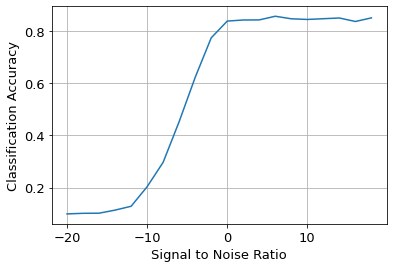

In [50]:
# Plot accuracy curve
plt.plot(snrs, list(map(lambda x: acc[x], snrs)))
plt.grid()
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy");